In [133]:
# This is the project code.

In [134]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("Project1") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") 

spark = configure_spark_with_delta_pip(builder).getOrCreate()
spark.sparkContext.setCheckpointDir("checkpoints/test/")

#spark.conf.set("spark.sql.repl.eagerEval.enabled",True) # OK for exploration, not great for performance
#spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)

In [135]:
import pandas as pd
import json
import numpy as np
import shapely
from shapely import Point
from shapely.geometry import mapping, shape
import pyspark.sql.functions as F
from pyspark.sql import Window
from shapely import Polygon
from pyspark.sql.functions import col, count, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructField, StructType, TimestampType
from shapely.strtree import STRtree
import matplotlib.pyplot as plt

## Reading in data

In [136]:
dataSchema = StructType([
    StructField("medallion",StringType(),True),
    StructField("hack_license",StringType(),True),
    StructField("vendor_id",StringType(),True),
    StructField("rate_code",IntegerType(),True),
    StructField("store_and_fwd_flag",StringType(),True),
    StructField("pickup_datetime",TimestampType(),True),
    StructField("dropoff_datetime",TimestampType(),True),
    StructField("passenger_count",IntegerType(),True),
    StructField("trip_time_in_secs",IntegerType(),True),
    StructField("trip_distance",DoubleType(),True),
    StructField("pickup_longitude",DoubleType(),True),
    StructField("pickup_latitude",DoubleType(),True),
    StructField("dropoff_longitude",DoubleType(),True),
    StructField("dropoff_latitude",DoubleType(),True),
])    

# Reading in taxi dataset
taxiDataDf = (spark.read
             .option("sep", ",") # separator
             .option("header", True) # file has header row
             .schema(dataSchema)
             #.option("inferSchema", True) # spark tries to infer data types
             .csv("sample.csv") #path
            ) \
            .dropna(subset=["pickup_datetime","dropoff_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]) \
            .drop("vendor_id","rate_code","store_and_fwd_flag")

In [137]:
#taxiDataDf.printSchema()

In [138]:
display(taxiDataDf)

DataFrame[medallion: string, hack_license: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: int, trip_time_in_secs: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double]

In [139]:
# Reading in borough dataset
with open('nyc-boroughs.geojson') as file:
    boroughs = json.load(file)

features = boroughs['features']
properties = [feature['properties'] for feature in features]
geometry = [feature['geometry'] for feature in features]

rowNumberWindow = Window.orderBy(F.lit("a"))

properties_df = spark.createDataFrame(properties).withColumn("rid",F.row_number().over(rowNumberWindow))
geometry_df = spark.createDataFrame(geometry).withColumn("rid",F.row_number().over(rowNumberWindow))
borough_base_df = properties_df.join(geometry_df,("rid")).drop("rid") #rid - row_id

In [140]:
display(borough_base_df)

DataFrame[@id: string, borough: string, boroughCode: bigint, coordinates: array<array<array<double>>>, type: string]

In [141]:
# Finding the area size of the boroughs
def calculate_area(coordinates):
    polygon = Polygon(list(coordinates[0]))
    return polygon.area

calculate_area_udf = F.udf(calculate_area,DoubleType())

borough_df_sorted = borough_base_df.withColumn("area",calculate_area_udf(F.col("coordinates"))) \
                            .sort(F.col("area").desc()) \
                            .withColumn("row_id",F.row_number().over(rowNumberWindow) - 1)


# https://shapely.readthedocs.io/en/stable/strtree.html
geomtree = STRtree([Polygon(coords["coordinates"][0]) for coords in borough_df_sorted.select("coordinates").collect()])
borough_df_sorted

DataFrame[@id: string, borough: string, boroughCode: bigint, coordinates: array<array<array<double>>>, type: string, area: double, row_id: int]

In [142]:
borough_df_sorted.show()

+--------------------+-------------+-----------+--------------------+-------+--------------------+------+
|                 @id|      borough|boroughCode|         coordinates|   type|                area|row_id|
+--------------------+-------------+-----------+--------------------+-------+--------------------+------+
|http://nyc.pediac...|       Queens|          4|[[[-73.8914505558...|Polygon| 0.02719387322630712|     0|
|http://nyc.pediac...|     Brooklyn|          3|[[[-73.9543955541...|Polygon| 0.01870558901900347|     1|
|http://nyc.pediac...|Staten Island|          5|[[[-74.0822127291...|Polygon| 0.01603547601912208|     2|
|http://nyc.pediac...|        Bronx|          2|[[[-73.8729486035...|Polygon|0.011405869460254603|     3|
|http://nyc.pediac...|    Manhattan|          1|[[[-73.9264055692...|Polygon|0.005859077996035753|     4|
|http://nyc.pediac...|       Queens|          4|[[[-73.8049919885...|Polygon|0.002244027128579165|     5|
|http://nyc.pediac...|       Queens|          

In [143]:
borough_df_sorted.count()

104

In [144]:
def findBorough(x,y):
    point = Point(x,y)
    nearestLocIndex = geomtree.nearest(point)
    return nearestLocIndex

In [145]:

# Define a function to find the point borough
def update_borough(longitude, latitude):
    borough = findBorough(longitude, latitude)
    return int(borough) if borough is not None else -1

# Create a user-defined function (UDF)
update_borough_udf = F.udf(update_borough, IntegerType())

# Apply the UDF to update the start and end borough column (finding the borough index)
taxiDataDf_with_boroughs = taxiDataDf.withColumn("startBoroughIndex", update_borough_udf(taxiDataDf["pickup_longitude"], taxiDataDf["pickup_latitude"]))


taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.withColumn("endBoroughIndex", update_borough_udf(taxiDataDf["dropoff_longitude"], taxiDataDf["dropoff_latitude"]))

taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.join(borough_df_sorted,taxiDataDf_with_boroughs.startBoroughIndex == borough_df_sorted.row_id,"left").drop("@id","coordinates","type","area","row_id").withColumnRenamed("borough","startBorough").withColumnRenamed("boroughCode","startBoroughCode")
taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.join(borough_df_sorted,taxiDataDf_with_boroughs.endBoroughIndex == borough_df_sorted.row_id,"left").drop("@id","coordinates","type","area","row_id").withColumnRenamed("borough","endBorough").withColumnRenamed("boroughCode","endBoroughCode")
#Checkpoint here to truncate the query plan and make computing question 3 and 4 faster
taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.checkpoint()

taxiDataDf_with_boroughs.show()


+--------------------+--------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------------+---------------+------------+----------------+----------+--------------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|startBoroughIndex|endBoroughIndex|startBorough|startBoroughCode|endBorough|endBoroughCode|
+--------------------+--------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-----------------+---------------+------------+----------------+----------+--------------+
|671165D7C5488407C...|CC998826ADAEDD02B...|2013-01-13 03:57:00|2013-01-13 03:57:00|              1|                0|          0.0

In [146]:
#taxiDataDf_with_boroughs.groupBy("startBoroughIndex").count().orderBy("startBoroughIndex").show()

## Query 1: Utilization

Utilization: This is per taxi/driver. This can be computed by computing the idle 
time per taxi. We will elaborate on that more later

In [147]:
taxiUtilizationBaseDf = taxiDataDf_with_boroughs.filter("trip_time_in_secs > 0 or trip_time_in_secs <= 3600 * 4")
              

utilizationWindow = Window.partitionBy("hack_license").orderBy("pickup_datetime")

idleTimeDf = taxiUtilizationBaseDf.withColumn("idle_time",(F.col("pickup_datetime") - F.lag(F.col("dropoff_datetime")).over(utilizationWindow)).cast("long")) \
                                  .fillna(0,subset=["idle_time"])
display(idleTimeDf)

DataFrame[medallion: string, hack_license: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: int, trip_time_in_secs: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, startBoroughIndex: int, endBoroughIndex: int, startBorough: string, startBoroughCode: bigint, endBorough: string, endBoroughCode: bigint, idle_time: bigint]

In [148]:
query1_df = idleTimeDf.groupBy("hack_license").agg(F.sum("idle_time").alias("idle_time_sum_seconds"))
display(query1_df)

DataFrame[hack_license: string, idle_time_sum_seconds: bigint]

In [149]:
#Save result to file
query1_df.coalesce(1).write.mode("overwrite").csv("results/test/query1.csv",header=True)

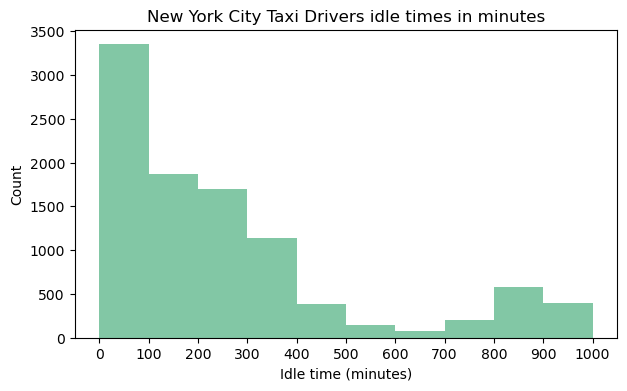

In [150]:
# Plotting the results

pandas_query1_df = query1_df.toPandas()
idle_time = pandas_query1_df.get("idle_time_sum_seconds")
idle_time_minutes = [ int(x/60) for x in idle_time]

# NB! Over 1000 minutes is missing!!!
fig = plt.figure(figsize = (7, 4))

bins= [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] # NB! Over 1000 minutes values are missing!!!
plt.hist(idle_time_minutes, bins=bins, color="#82c7a5ff")
plt.xticks(bins)
plt.xlabel("Idle time (minutes)")
plt.ylabel("Count")
plt.title("New York City Taxi Drivers idle times in minutes")
plt.savefig(fname="plots/test/q1.png")
plt.savefig(fname="plots/test/q1.svg")
plt.show()

## Query 2: Average next trip time

The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up.


In [151]:
taxiDataDf_with_boroughs.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- startBoroughIndex: integer (nullable = true)
 |-- endBoroughIndex: integer (nullable = true)
 |-- startBorough: string (nullable = true)
 |-- startBoroughCode: long (nullable = true)
 |-- endBorough: string (nullable = true)
 |-- endBoroughCode: long (nullable = true)



In [152]:
from pyspark.sql.functions import col, unix_timestamp, lead, avg, round

windowSpec = Window.partitionBy("hack_license").orderBy("dropoff_datetime")

df = taxiDataDf_with_boroughs.withColumn("next_pickup_time", lead("pickup_datetime").over(windowSpec))
df = df.withColumn("time_to_next_fare", unix_timestamp("next_pickup_time") - unix_timestamp("dropoff_datetime"))
df = df.filter((col("time_to_next_fare") >= 0) & (col("time_to_next_fare") <= 3600*4))  

#result_df = df.join(borough_df_sorted, df.endBoroughIndex == borough_df_sorted.row_id)
avg_wait_time_per_borough = df.groupBy("endBorough").agg(round(avg("time_to_next_fare") / 60 , 2).alias("avg_waiting_time_minutes"))

avg_wait_time_per_borough.show()

+-------------+------------------------+
|   endBorough|avg_waiting_time_minutes|
+-------------+------------------------+
|       Queens|                   38.17|
|     Brooklyn|                   34.58|
|Staten Island|                   41.09|
|    Manhattan|                   15.03|
|        Bronx|                   37.94|
+-------------+------------------------+



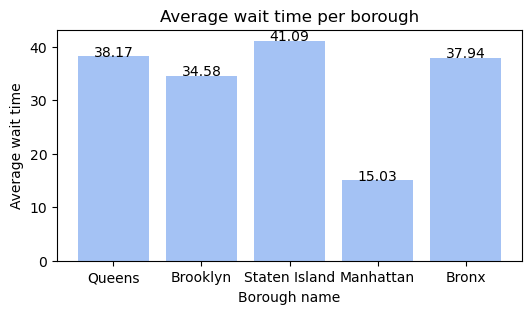

In [153]:
# Plotting the query2
pandas_query2_df = avg_wait_time_per_borough.toPandas()

fig = plt.figure(figsize = (6, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = pandas_query2_df.get("endBorough")
y = pandas_query2_df.get("avg_waiting_time_minutes")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff')

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Average wait time")
plt.title("Average wait time per borough")
plt.savefig(fname="plots/test/q2.png")
plt.savefig(fname="plots/test/q2.svg")
plt.show()

## Query 3: Trips started in one borough

The number of trips that started and ended within the same borough,


In [154]:
same_borough_df = taxiDataDf_with_boroughs.filter(F.col("startBoroughCode") == F.col("endBoroughCode"))
print("The number of trips that start and end in the same borough is " + str(same_borough_df.count()) + ".")

The number of trips that start and end in the same borough is 88081.


In [155]:
same_borough_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- startBoroughIndex: integer (nullable = true)
 |-- endBoroughIndex: integer (nullable = true)
 |-- startBorough: string (nullable = true)
 |-- startBoroughCode: long (nullable = true)
 |-- endBorough: string (nullable = true)
 |-- endBoroughCode: long (nullable = true)



### Plots

In [156]:
query3_df = same_borough_df.groupBy("startBorough").count()

query3_df.show()

+-------------+-----+
| startBorough|count|
+-------------+-----+
|       Queens| 3217|
|     Brooklyn| 1069|
|Staten Island|   20|
|    Manhattan|83719|
|        Bronx|   56|
+-------------+-----+



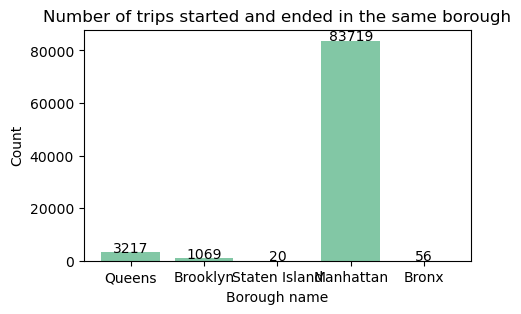

In [157]:
# Plotting the query3 results

query3_df_pandas = query3_df.toPandas()

fig = plt.figure(figsize = (5, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query3_df_pandas.get("startBorough")
y = query3_df_pandas.get("count")
# creating the bar plot
plt.bar(x, y, color ='#82c7a5ff')

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in the same borough")
plt.savefig(fname="plots/test/q3.png")
plt.savefig(fname="plots/test/q3.svg")
plt.show()

## Query 4: Trips between different boroughs

The number of trips that started in one borough and ended in another one

In [158]:
different_borough_df = taxiDataDf_with_boroughs.filter(F.col("startBoroughCode") != F.col("endBoroughCode"))
print("The number of trips that have different start and end borough is " + str(different_borough_df.count()) + ".")

The number of trips that have different start and end borough is 11918.


### Plots

In [159]:
query4_start_df = different_borough_df.groupBy("startBorough").count()

query4_start_df.show()

+-------------+-----+
| startBorough|count|
+-------------+-----+
|       Queens| 4493|
|     Brooklyn|  901|
|Staten Island|    7|
|    Manhattan| 6480|
|        Bronx|   37|
+-------------+-----+



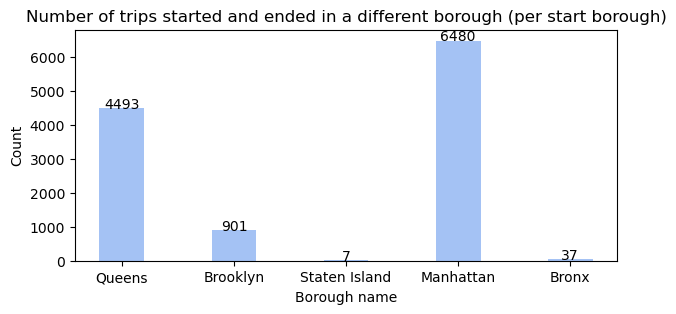

In [160]:
# Plotting the query4 results (start borough)

query4_start_df_pandas = query4_start_df.toPandas()

fig = plt.figure(figsize = (7, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query4_start_df_pandas.get("startBorough")
y = query4_start_df_pandas.get("count")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff', width=0.4)

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in a different borough (per start borough)")
plt.savefig(fname="plots/test/q4.png")
plt.savefig(fname="plots/test/q4.svg")
plt.show()